In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torchvision
from torchvision import transforms, datasets

import torch.nn as nn

import numpy as np

import helper

print("[INFO] torch loaded")

[INFO] torch loaded


Carga de datos del dataset de Kuzushiji-MNIST de Anokas

In [2]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

print("[INFO] loading the KMNIST dataset...")
arr_train_img = np.load("../input/kuzushiji/kmnist-train-imgs.npz")['arr_0']
arr_train_label = np.load("../input/kuzushiji/kmnist-train-labels.npz")['arr_0']
arr_test_img = np.load("../input/kuzushiji/kmnist-test-imgs.npz")['arr_0']
arr_test_label = np.load("../input/kuzushiji/kmnist-test-imgs.npz")['arr_0']

train_tensor_img = torch.from_numpy(arr_train_img)
train_tensor_label = torch.from_numpy(arr_train_label)
test_tensor_img = torch.from_numpy(arr_test_img)
test_tensor_label = torch.from_numpy(arr_test_label)


print("[INFO] KMNIST dataset 50% loaded")

[INFO] loading the KMNIST dataset...
[INFO] KMNIST dataset 50% loaded


Clases, hiperparametros y Dataloader de pytorch estableciendo set de entrenamiento y set de pruebas

In [3]:
#HIPERPARAMETROS Y DEMAS

# Creando las clases para los diferentes familias de caracteres para clasificar
classes = ('Vocales', 'Familia de K', 'Familia de S', 'Familia de T'
           , 'Familia de N', 'Familia de H', 'Familia de M', 'Familia de Y'
           , 'Familia de R', 'Familia de W')

# Definimos el tamaños de los batch, los Epoch y el rate de aprendizaje
batch_size = 64
learning_rate = 0.01
drop_rate = 0.25
epochs = 60


trainset = torch.utils.data.TensorDataset(train_tensor_img,train_tensor_label)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)

testset = torch.utils.data.TensorDataset(test_tensor_img,test_tensor_label)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

print("[INFO] KMNIST dataset loaded")

[INFO] KMNIST dataset loaded


OPCIONAL: Visualizacion de datos cargados del dataset

De izquierda a derecha
Valor: 8 Clasificacion: Familia de R
Valor: 7 Clasificacion: Familia de Y
Valor: 0 Clasificacion: Vocales
Valor: 1 Clasificacion: Familia de K


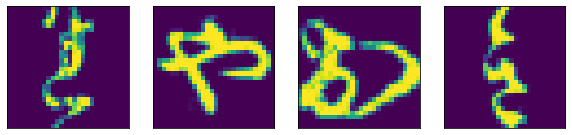

In [4]:
#HELPER TO VISUALIZE IMAGES
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()


    ax.imshow(image)
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print("De izquierda a derecha")
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax)
    print("Valor: " + str(labels[ii].item()) + " Clasificacion: " +classes[labels[ii].item()])

MODELOS DE REDES NEURONALES